In [6]:
import numpy as np
import pandas as pd
import pymysql
import os, sys
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import time

basePath = "..\\dataset"

#### 通过mysql读取数据

In [7]:
# st = time.time()
# conn = pymysql.connect(port=3307, user="root", password="root", database="pp", host="127.0.0.1", charset='utf8')
# query = "select * from banner_carr"
# df_banner = pd.read_sql(query, con=conn)
# et = time.time()
# print("mysql cost time: ", et - st)
# # df_banner.head()

In [8]:
# filePath = os.path.join(basePath, "banner_carr.csv")
# df_banner.to_csv(filePath)

#### 同是读取27万，mysql竟然需要40.13秒，但是pandas竟然只需要1.2秒，这个比较有点伤害啊

In [40]:
st = time.time()
filePath = os.path.join(basePath, "banner_carr.csv")
df_banner=pd.read_csv(filePath)
et = time.time()
print("cost time: ", et -st)
#df_banner2.head()

cost time:  1.050985336303711


#### pandas太强大了，一个mean自动把字符串类型的类（banner_name）直接给干掉了，当然后续如果还是需要banner_name参与进来的话需要先把这一列给给encode了，否则直接就没了

In [41]:
df_banner_agg = df_banner.drop("id", axis=1).groupby("REPORT_DATE").mean().reset_index()

#df_banner_agg["REPORT_DATE"] = df_banner_agg["REPORT_DATE"].apply(lambda x: x.replace("/", "-"))
df_banner_agg.head(1)

,REPORT_DATE,Unnamed: 0,AMOUNT_PER_KG,PRICE_PER_KG,HAS_GROUND,WEEK_OF_YEAR,MONTH_OF_YEAR,YEAR_OF_WEEK,IS_VALENTINE,IS_TEACHER,...,IS_NEWYEAR,IS_CHRISTMAS,IS_12,IS_11,IS_618,IS_SUMMER,IS_WINTER,STORE_COUNT,CITY_COUNT,RN
0,2016-09-01,257389.5,7.390457,86.396316,0.070796,35.0,9.0,2016.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,288.0,67.0,1.0


In [42]:
import datetime
def getDayNo(arr):
    count = len(arr)
    for i in range(count):
        dd = arr[i]
        dd = datetime.datetime.strptime(dd,"%Y-%m-%d")

        dayNo = dd.timetuple().tm_yday
        arr[i] = dayNo
        #print("date:", dd, "; dayNo: ", dayNo)

In [43]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train_predict, y_train[:m]))
        val_errors.append(mean_squared_error(y_val_predict, y_val))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")

#plot_learning_curves(rf, X_train, y_train)

In [44]:
def model_train(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    yHat = model.predict(X_test)
    #plt.figure(figsize=(15, 12))
    plt.plot(range(len(yHat)), yHat, "r-")
    plt.plot(range(len(y_test)), y_test, "b--")
    from sklearn.metrics import mean_squared_error
    mse = mean_squared_error(y_test, yHat)
    print("mse: ", mse, "rmse: ", np.sqrt(mse))
    #plot_learning_curves(rf, X_train, y_train)

In [45]:
# 获取趋势聚合信息
filePath = os.path.join(basePath, "SalesTrend.csv")
df_trend = pd.read_csv(filePath)
df_trend_carre = df_trend[df_trend.BANNER_NAME == 'Carrefour']
df_trend_carre_agg = df_trend_carre.groupby('REPORT_DATE').mean().reset_index()
df_trend_carre_agg.head(3)

,REPORT_DATE,QLI,LAST_1_MONTH_AVG,LAST_1_MONTH_MIN,LAST_1_MONTH_MAX,LAST_1_MONTH_SUM,LAST_1_MONTH_MID,LAST_1_MONTH_MID25,LAST_1_MONTH_MID75,LAST_2_MONTH_AVG,...,LAST_6_MONTH_MID,LAST_6_MONTH_MID25,LAST_6_MONTH_MID75,LAST_12_MONTH_AVG,LAST_12_MONTH_MIN,LAST_12_MONTH_MAX,LAST_12_MONTH_SUM,LAST_12_MONTH_MID,LAST_12_MONTH_MID25,LAST_12_MONTH_MID75
0,2016-09-01,0.632679,0.632679,0.632679,0.632679,0.632679,0.632679,0.632679,0.632679,0.632679,...,0.632679,0.632679,0.632679,0.632679,0.632679,0.632679,0.632679,0.632679,0.632679,0.632679
1,2016-09-02,0.419916,0.541714,0.331946,0.751482,1.090651,0.541714,0.541714,0.541714,0.541714,...,0.541714,0.541714,0.541714,0.541714,0.331946,0.751482,1.090651,0.541714,0.541714,0.541714
2,2016-09-03,0.142710,0.597410,0.099664,1.098178,1.792231,0.594389,0.347027,0.846284,0.597410,...,0.594389,0.347027,0.846284,0.597410,0.099664,1.098178,1.792231,0.594389,0.347027,0.846284


In [46]:
df_merge = df_banner_agg.merge(df_trend_carre_agg, on=["REPORT_DATE"], how="inner")
len(df_merge)
#df_merge.columns

654

In [54]:
labels = df_merge["QLI"].values
df_merge_clean = df_merge.copy()
getDayNo(df_merge_clean["REPORT_DATE"].values)
df_merge_clean = df_merge_clean.drop("QLI", 1)
df_merge_clean.head(1)

,REPORT_DATE,Unnamed: 0,AMOUNT_PER_KG,PRICE_PER_KG,HAS_GROUND,WEEK_OF_YEAR,MONTH_OF_YEAR,YEAR_OF_WEEK,IS_VALENTINE,IS_TEACHER,...,LAST_6_MONTH_MID,LAST_6_MONTH_MID25,LAST_6_MONTH_MID75,LAST_12_MONTH_AVG,LAST_12_MONTH_MIN,LAST_12_MONTH_MAX,LAST_12_MONTH_SUM,LAST_12_MONTH_MID,LAST_12_MONTH_MID25,LAST_12_MONTH_MID75
0,245,257389.5,7.390457,86.396316,0.070796,35.0,9.0,2016.0,0.0,0.0,...,0.632679,0.632679,0.632679,0.632679,0.632679,0.632679,0.632679,0.632679,0.632679,0.632679


In [55]:
len(df_merge_clean)

654

In [56]:
X_train, X_test, y_train, y_test = train_test_split(df_merge_clean.values, labels, test_size=0.2, random_state=42)

mse:  2.0381387694049318 rmse:  1.4276339759913714


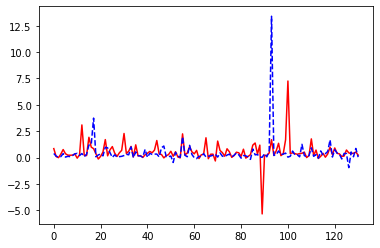

In [57]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
model_train(lr, X_train, y_train, X_test, y_test)

c:\users\wenyang.zhang\documents\myspace\python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


mse:  1.4474719092476627 rmse:  1.2031092673766846


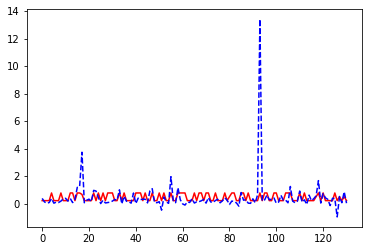

In [58]:
rf = RandomForestRegressor(random_state=42,min_samples_leaf=150)
model_train(rf, X_train, y_train, X_test, y_test)

c:\users\wenyang.zhang\documents\myspace\python37\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


mse:  1.5222216724587816 rmse:  1.2337834787590494


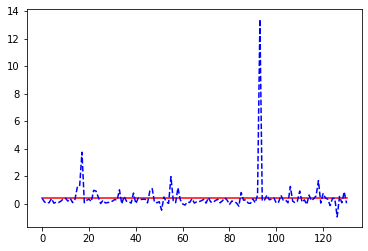

In [59]:
from sklearn.svm import SVR
svr =SVR()
model_train(svr, X_train, y_train, X_test, y_test)

mse:  1.705754181067811 rmse:  1.30604524464806


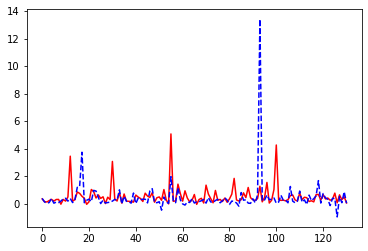

In [60]:
gbr = GradientBoostingRegressor()
model_train(gbr, X_train, y_train, X_test, y_test)